In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from THESIS import LightCurveSampler, ModelComparison, JAXNSmodelCreator
from NSmodels_graham import *
import corner
import tqdm

INFO[2026-02-05 11:25:35,159]: Unable to initialize backend 'cuda': 
INFO[2026-02-05 11:25:35,160]: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2026-02-05 11:25:35,161]: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO[2026-02-05 11:25:36,466]: arviz_base not installed
INFO[2026-02-05 11:25:36,468]: arviz_stats not installed
INFO[2026-02-05 11:25:36,468]: arviz_plots not installed


In [2]:
def sort_arrays_together(time, flux, err=[None]):
        """
        Sorts two arrays (time and flux) together based on the values of the time array.

        Parameters:
        - time: array-like, array to be sorted
        - flux: array-like, corresponding flux values

        Returns:
        - sorted_time: array-like, sorted time array
        - sorted_flux: array-like, corresponding flux values sorted based on time
        """
        indices = np.argsort(time)
        sorted_time = time[indices]
        sorted_flux = flux[indices]
        if err[0]!=None:
            sorted_flux_err = err[indices]
            return sorted_time, sorted_flux, sorted_flux_err
        else:
            return sorted_time, sorted_flux
        
        
def sample_posterior(param_samples, num_samples):
    
    num_params = param_samples.shape[1]

    sampled_indices = np.random.choice(param_samples.shape[0], size=num_samples, replace=False)

    sampled_params = param_samples[sampled_indices]

    return sampled_params

def plot_corner(dictionary, exclude_keys=['log_Z_mean', 'log_Z_uncert']):
    if exclude_keys is None:
        exclude_keys = []

    filtered_data = {key: value for key, value in dictionary.items() if key not in exclude_keys}

    data = np.array([array for array in filtered_data.values()]).T
    
    fig = corner.corner(data, bins=50 ,  labels=list(filtered_data.keys()), show_titles=True, title_quantiles=[0.16,0.5,0.84], title_kwargs={"fontsize": 12}, quantiles=(0.16, 0.84))
    
    plt.show()

In [3]:
LCdata = pd.read_csv('AGNobsdata/graham2015data.csv')
LCdata['years'] = (LCdata.MJD.to_numpy() - LCdata.MJD.to_numpy()[0])/365
lcTIME = LCdata.years.to_numpy()
lcFLUX = LCdata.Mag.to_numpy() - np.median(LCdata.Mag.to_numpy())
lcFLUXerr = LCdata.Magerr.to_numpy()

lcTIME, lcFLUX, lcFLUXerr = sort_arrays_together(lcTIME, lcFLUX, lcFLUXerr)

<ErrorbarContainer object of 3 artists>

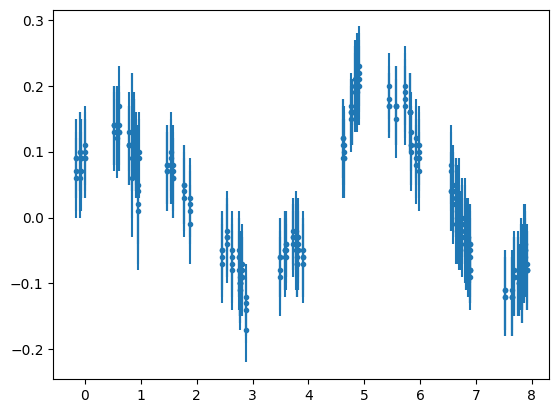

In [4]:
plt.errorbar(lcTIME, lcFLUX, yerr=lcFLUXerr, fmt = '.')

In [5]:

modelCreater = JAXNSmodelCreator(lcTIME, lcFLUX, lcFLUXerr)


OBPL_10_NSmodel = modelCreater.create_model(OBPL_generative_prior, OBPL_log_likelihood_model, n_component = 10)

ModelCOMP = ModelComparison(lcTIME, lcFLUX,lcFLUXerr, verbose=True)
ModelCOMP.add_NestedModel(OBPL_10_NSmodel, 'OBPL_10')
ModelCOMP.run_NSsampler()

Model Comparion object created.
JAXNS model added.
Total number of models being sampled :  1
--------------------------------------------------------------------------
Model being sampled :  OBPL_10
-------------------------------------------------------------------------
DefaultNestedSampler Created. 
Sampling inititated.
Sampling finished.
TerminationCondition :  Small remaining evidence




In [6]:
OBPL_dict = ModelCOMP.return_samples_logZ_dict('OBPL_10')

WARNING[2026-02-05 11:28:27,703]: Too few points to create valid contours


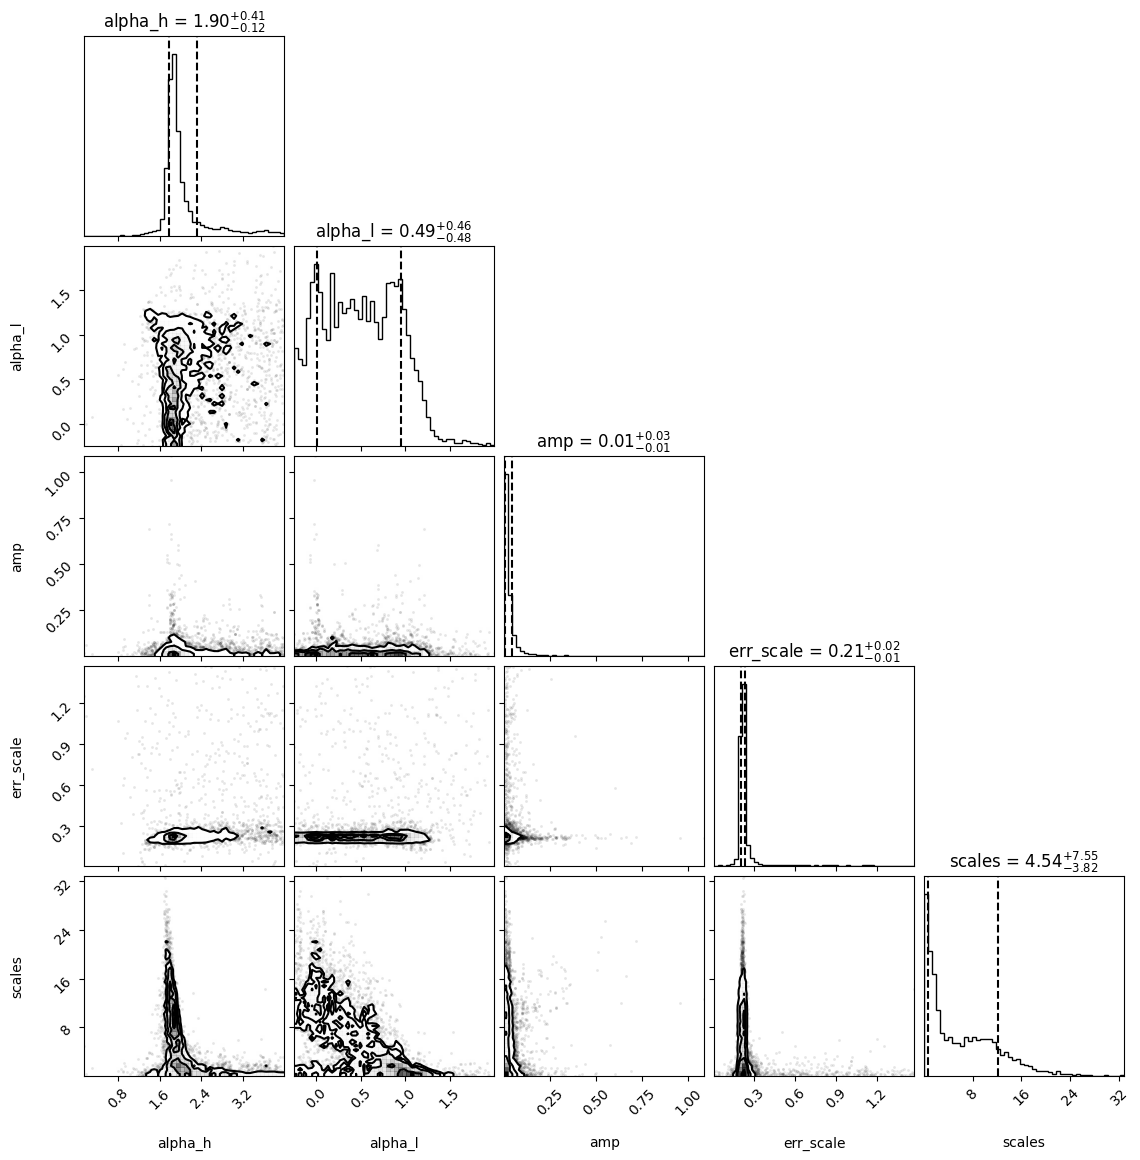

In [7]:
plot_corner(OBPL_dict)

In [8]:
def sample_posterior_within_1sigma(param_samples, num_samples):
    lower_quantiles, upper_quantiles = np.percentile(param_samples, [16, 84], axis=0)
    
    within_1sigma_mask = np.all((param_samples >= lower_quantiles) & (param_samples <= upper_quantiles), axis=1)
    filtered_samples = param_samples[within_1sigma_mask]
    
    if len(filtered_samples) < num_samples:
        raise ValueError("Not enough samples within 1σ to draw the desired number of samples")
    sampled_indices = np.random.choice(filtered_samples.shape[0], size=num_samples, replace=False)
    sampled_params = filtered_samples[sampled_indices]
    
    return sampled_params

In [9]:
def sample_posterior_within_1sigma(param_samples_dict, num_samples):
    # Extract parameter names and samples
    param_names = list(param_samples_dict.keys())
    param_samples = np.array(list(param_samples_dict.values()))
    
    # Calculate the 16th and 84th percentiles (1 sigma for a normal distribution)
    lower_quantiles, upper_quantiles = np.percentile(param_samples, [16, 84], axis=1)
    
    # Mask for samples within 1 sigma
    within_1sigma_mask = np.all((param_samples.T >= lower_quantiles) & (param_samples.T <= upper_quantiles), axis=1)
    filtered_samples = param_samples[:, within_1sigma_mask].T
    
    # Check if there are enough samples within 1 sigma
    if len(filtered_samples) < num_samples:
        raise ValueError("Not enough samples within 1σ to draw the desired number of samples")
    
    # Randomly sample the desired number of samples
    sampled_indices = np.random.choice(filtered_samples.shape[0], size=num_samples, replace=False)
    sampled_params = filtered_samples[sampled_indices]
    
    # Construct dictionary of sampled values
    sampled_values_dict = {param_names[i]: sampled_params[:, i] for i in range(len(param_names))}
    
    return sampled_values_dict

In [10]:
def filter_dict_by_keys(input_dict, keys):
    return {key: input_dict[key] for key in keys if key in input_dict}

OBPL_filtered = filter_dict_by_keys(OBPL_dict, ['alpha_h', 'alpha_l', 'amp', 'err_scale', 'scales'])

In [12]:
mat = sample_posterior_within_1sigma(np.array(list(OBPL_dict.values())[2:]).T, num_samples=100)

AttributeError: 'numpy.ndarray' object has no attribute 'keys'

In [ ]:
posterior_dataset = pd.DataFrame(mat, columns= ['alpha_h', 'alpha_l', 'err_scale', 'log_bend_freq', 'log_norm'])
posterior_dataset['simSEED'] = np.random.randint(0, 10000, size=100)
posterior_dataset

,alpha_h,alpha_l,err_scale,log_bend_freq,log_norm,simSEED
0,1.779774,0.082285,0.206987,-1.185305,-0.206455,2219
1,1.878974,0.266205,0.211214,-1.008952,1.992859,9628
2,1.967866,0.309825,0.230756,-1.311592,0.354524,5509
3,1.658301,0.668621,0.252512,-1.257107,0.055351,383
4,1.882848,0.164235,0.211622,-0.996133,0.620338,808
...,...,...,...,...,...,...
95,1.927672,0.239664,0.228483,-0.955130,0.469449,7666
96,1.777878,0.080884,0.220423,-1.040799,0.951821,7525
97,1.939357,0.926472,0.224465,-0.621505,1.762316,7005
98,1.837738,0.046553,0.236273,-0.922457,1.227944,2215


In [ ]:
alpha_h_array = mat.T[0]
alpha_l_array = mat.T[1]
err_scale_array = mat.T[2]
log_bend_freq_array = mat.T[3]
log_norm_array = mat.T[4]


In [52]:

def bend_pl(f, norm, f_bend, alph_lo, alph_hi, sharpness):
    # Bending power-law with two slopes, modified from Summons et al. 2007 
    # (http://adsabs.harvard.edu/abs/2007MNRAS.378..649S)
    # to include 'sharpness' parameter.  Sharpness = 1 same as simpler Summons et al. model, larger values
    # give a sharper transition from one slope to the other.
    # Typical slopes for AGN would be alph_lo=-1, alph_hi=-2 to -3
    powmod = (norm*(f/f_bend)**alph_lo)/(1.+(f/f_bend)**(sharpness*(alph_lo-alph_hi)))**(1./sharpness)
    return powmod

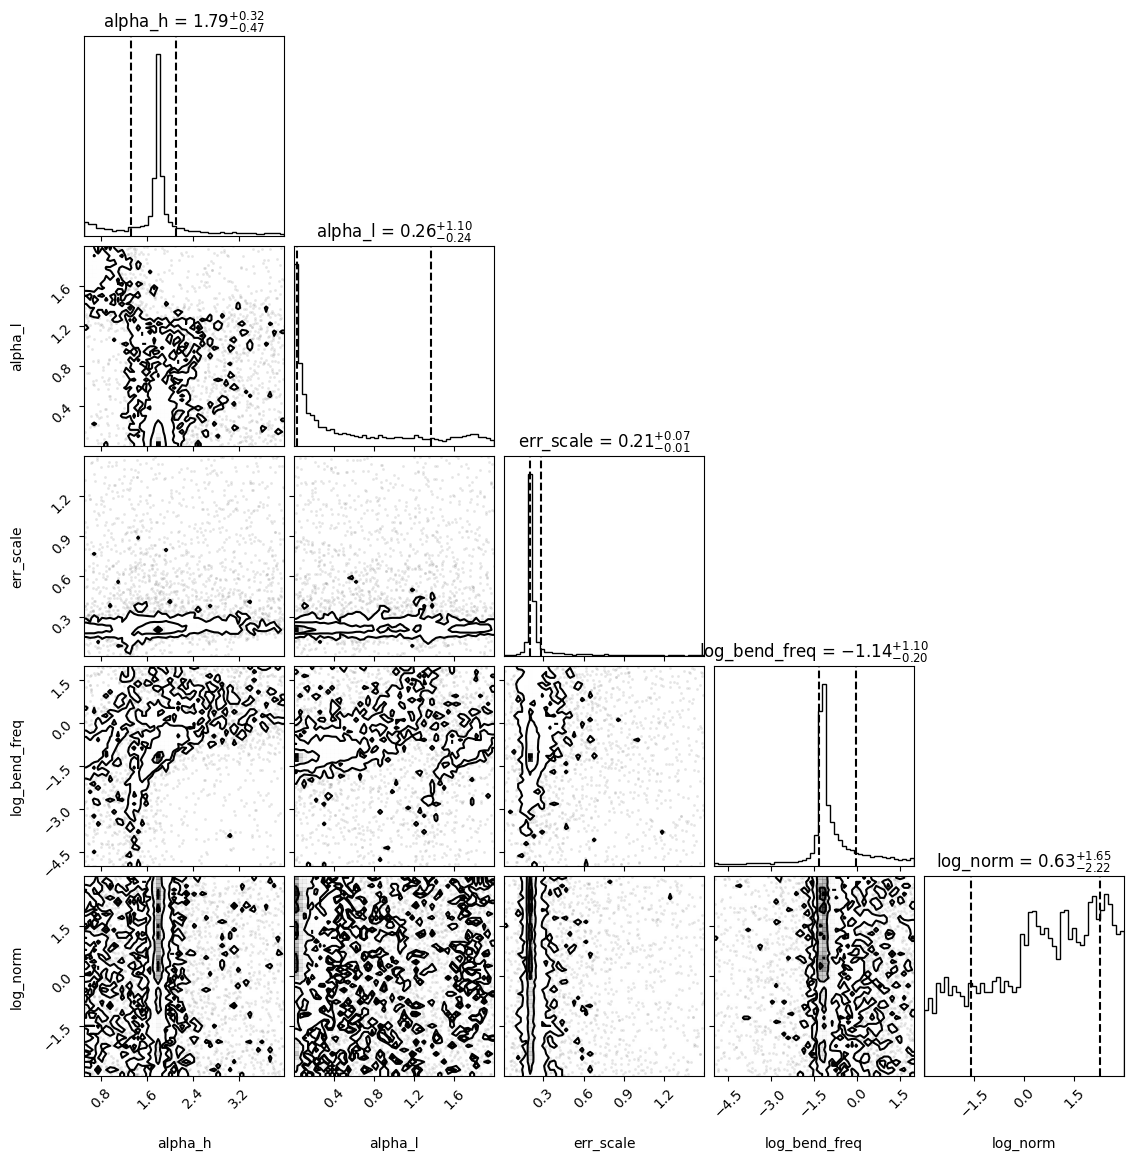

In [67]:
plot_corner(OBPL_dict)

In [55]:
psd = OneBendPowerLaw([np.power(10, log_norm_array[0]), alpha_l_array[0], 10**(log_bend_freq_array[0]), alpha_h_array[0]], free_parameters=[True]*4)
model_ACV = PSDToACV(psd, S_low=100,
            S_high=20,
            T=lcTIME[-1] - lcTIME[0],
            dt=np.min(np.diff(lcTIME)),
            method='SHO',
            n_components=10,
            estimate_variance=True,
            init_variance=jnp.var(lcFLUX, ddof=1),
            use_celerite=False,
            use_legacy_celerite=False )

kernel = model_ACV.ACVF

In [56]:
gp = GaussianProcess(kernel, jnp.array(lcTIME), diag = jnp.array((err_scale_array[0]*lcFLUXerr)**2), mean = jnp.array(0.0))

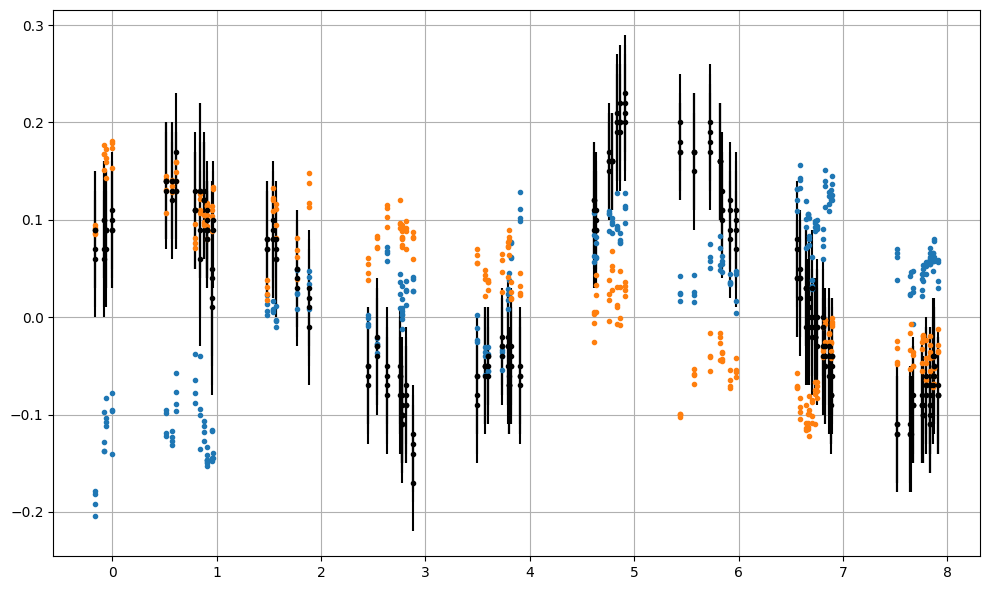

In [66]:
samples = gp.sample(jax.random.PRNGKey(1), shape = (3,))
plt.figure(figsize = [10,6])
plt.errorbar(lcTIME, lcFLUX, yerr = lcFLUXerr, fmt = '.', color = 'k')
plt.grid()
for i in range(2):
    plt.plot(lcTIME, samples[i], '.' )
plt.tight_layout()


In [17]:
pd.DataFrame(np.vstack((lcTIME, lcFLUX, lcFLUXerr)).T, columns=['time', 'flux', 'fluxerr']).to_csv('AGNobsdata/graham2015data.txt', header=False, index=False, sep = ' ')

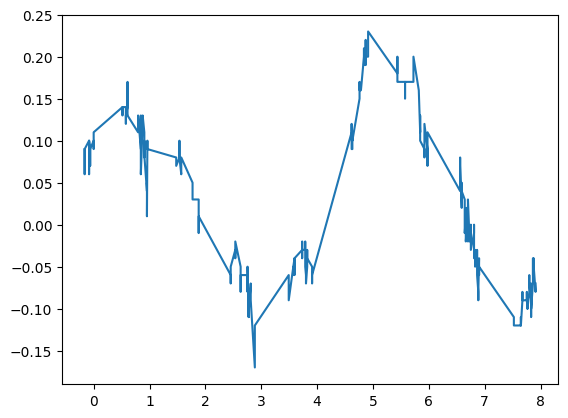

In [21]:
time, flux, fluxerr = np.loadtxt('AGNobsdata/graham2015data.txt').T
plt.plot(time, flux)

# The algorithm

In [85]:
import sys, os
def blockPrint():
    sys.stdout = open(os.devnull, 'w')

def enablePrint():
    sys.stdout = sys.__stdout__

def sample_posterior_within_1sigma(param_samples, num_samples):
    lower_quantiles, upper_quantiles = np.percentile(param_samples, [16, 84], axis=0)
    
    within_1sigma_mask = np.all((param_samples >= lower_quantiles) & (param_samples <= upper_quantiles), axis=1)
    filtered_samples = param_samples[within_1sigma_mask]
    
    if len(filtered_samples) < num_samples:
        raise ValueError("Not enough samples within 1σ to draw the desired number of samples")
    sampled_indices = np.random.choice(filtered_samples.shape[0], size=num_samples, replace=False)
    sampled_params = filtered_samples[sampled_indices]
    
    return sampled_params

def periodSIGNI(time, flux, fluxerr):
    modelCreater = JAXNSmodelCreator(time, flux, fluxerr)
    
    OBPL_10_NSmodel = modelCreater.create_model(OBPL_generative_prior, OBPL_log_likelihood_model, n_component = 10)
    OBPLsine_10_NSmodel = modelCreater.create_model(OBPLsine_generative_prior, OBPLsine_log_likelihood_model, n_component = 10)

    print('generating posteriors for OBPL parameters for given data...')
    blockPrint()
    ModelCOMP = ModelComparison(time, flux, fluxerr, verbose=True)
    ModelCOMP.add_NestedModel(OBPL_10_NSmodel, 'OBPL10')
    ModelCOMP.add_NestedModel(OBPLsine_10_NSmodel, 'OBPL10sine')
    ModelCOMP.run_NSsampler()
    enablePrint()
    print('Posteriors generated...')
    
    
    OBPL_dict = ModelCOMP.return_samples_logZ_dict('OBPL10')
    org_data_bayes = np.exp()
    del ModelCOMP, modelCreater
    
    mat = sample_posterior_within_1sigma(np.array(list(OBPL_dict.values())[2:]).T, num_samples=100)
    
    alpha_h_array = mat.T[0]
    alpha_l_array = mat.T[1]
    err_scale_array = mat.T[2]
    log_bend_freq_array = mat.T[3]
    log_norm_array = mat.T[4]
    
    # posterior_dataset = pd.DataFrame(mat, columns= ['alpha_h', 'alpha_l', 'err_scale', 'log_bend_freq', 'log_norm'])
    
    logZ_OBPL = []
    logZ_OBPLsine = []
    bayes_OBPL_OBPLsine = []
    print('False positivity test initiated...')
    
    for i in range(100):
        print(i, end='-->')
        psd = OneBendPowerLaw([np.power(10, log_norm_array[i]), alpha_l_array[i], 10**(log_bend_freq_array[i]), alpha_h_array[i]], free_parameters=[True]*4)
        model_ACV = PSDToACV(psd, S_low=100,
                    S_high=20,
                    T=lcTIME[-1] - lcTIME[0],
                    dt=np.min(np.diff(lcTIME)),
                    method='SHO',
                    n_components=10,
                    estimate_variance=True,
                    init_variance=jnp.var(lcFLUX, ddof=1),
                    use_celerite=False,
                    use_legacy_celerite=False )

        kernel = model_ACV.ACVF
        gp = GaussianProcess(kernel, jnp.array(time), diag = jnp.array((err_scale_array[i]*fluxerr)**2), mean = jnp.array(0.0))
        y_gen_time = np.array(time).copy()
        y_gen = gp.sample(jax.random.PRNGKey(1))
        y_gen_err =  np.random.normal(np.mean(fluxerr), np.std(fluxerr))
        
        modelCreater = JAXNSmodelCreator(y_gen_time, y_gen, y_gen_err)
    
        OBPL_10_NSmodel = modelCreater.create_model(OBPL_generative_prior, OBPL_log_likelihood_model, n_component = 10)
        OBPLsine_10_NSmodel = modelCreater.create_model(OBPLsine_generative_prior, OBPLsine_log_likelihood_model, n_component = 10)
        blockPrint()
        ModelCOMP = ModelComparison(y_gen_time, y_gen, y_gen_err, verbose=True)
        ModelCOMP.add_NestedModel(OBPL_10_NSmodel, 'OBPL10')
        ModelCOMP.add_NestedModel(OBPLsine_10_NSmodel, 'OBPL10sine')
        ModelCOMP.run_NSsampler()
        enablePrint()
        OBPL_dict = ModelCOMP.return_samples_logZ_dict('OBPL10')
        OBPLsine_dict = ModelCOMP.return_samples_logZ_dict('OBPL10sine')
        
        logZ_OBPL.append(OBPL_dict['log_Z_mean'])
        logZ_OBPLsine.append(OBPLsine_dict['log_Z_mean'])
        bayes_OBPL_OBPLsine.append(np.exp(logZ_OBPL-logZ_OBPLsine))
        
        
    return bayes_OBPL_OBPLsine
        
        
        
        
        

In [86]:
time, flux, fluxerr = lcTIME, lcFLUX, lcFLUXerr
modelCreater = JAXNSmodelCreator(time, flux, fluxerr)
    
OBPL_10_NSmodel = modelCreater.create_model(OBPL_generative_prior, OBPL_log_likelihood_model, n_component = 10)
OBPLsine_10_NSmodel = modelCreater.create_model(OBPLsine_generative_prior, OBPLsine_log_likelihood_model, n_component = 10)

print('generating posteriors for OBPL parameters for given data...')
blockPrint()
ModelCOMP = ModelComparison(time, flux, fluxerr, verbose=True)
ModelCOMP.add_NestedModel(OBPL_10_NSmodel, 'OBPL10')
ModelCOMP.add_NestedModel(OBPLsine_10_NSmodel, 'OBPL10sine')
ModelCOMP.run_NSsampler()
enablePrint()
print('Posteriors generated...')


OBPL_dict = ModelCOMP.return_samples_logZ_dict('OBPL10')
org_data_bayes = np.exp()
del ModelCOMP, modelCreater

mat = sample_posterior_within_1sigma(np.array(list(OBPL_dict.values())[2:]).T, num_samples=100)

alpha_h_array = mat.T[0]
alpha_l_array = mat.T[1]
err_scale_array = mat.T[2]
log_bend_freq_array = mat.T[3]
log_norm_array = mat.T[4]

# posterior_dataset = pd.DataFrame(mat, columns= ['alpha_h', 'alpha_l', 'err_scale', 'log_bend_freq', 'log_norm'])

logZ_OBPL = []
logZ_OBPLsine = []
bayes_OBPL_OBPLsine = []
print('False positivity test initiated...')

for i in range(100):
    print(i, end='-->')
    psd = OneBendPowerLaw([np.power(10, log_norm_array[i]), alpha_l_array[i], 10**(log_bend_freq_array[i]), alpha_h_array[i]], free_parameters=[True]*4)
    model_ACV = PSDToACV(psd, S_low=100,
                S_high=20,
                T=lcTIME[-1] - lcTIME[0],
                dt=np.min(np.diff(lcTIME)),
                method='SHO',
                n_components=10,
                estimate_variance=True,
                init_variance=jnp.var(lcFLUX, ddof=1),
                use_celerite=False,
                use_legacy_celerite=False )

    kernel = model_ACV.ACVF
    gp = GaussianProcess(kernel, jnp.array(time), diag = jnp.array((err_scale_array[i]*fluxerr)**2), mean = jnp.array(0.0))
    y_gen_time = np.array(time).copy()
    y_gen = gp.sample(jax.random.PRNGKey(1))
    y_gen_err =  np.random.normal(np.mean(fluxerr), np.std(fluxerr))
    
    modelCreater = JAXNSmodelCreator(y_gen_time, y_gen, y_gen_err)

    OBPL_10_NSmodel = modelCreater.create_model(OBPL_generative_prior, OBPL_log_likelihood_model, n_component = 10)
    OBPLsine_10_NSmodel = modelCreater.create_model(OBPLsine_generative_prior, OBPLsine_log_likelihood_model, n_component = 10)
    blockPrint()
    ModelCOMP = ModelComparison(y_gen_time, y_gen, y_gen_err, verbose=True)
    ModelCOMP.add_NestedModel(OBPL_10_NSmodel, 'OBPL10')
    ModelCOMP.add_NestedModel(OBPLsine_10_NSmodel, 'OBPL10sine')
    ModelCOMP.run_NSsampler()
    enablePrint()
    OBPL_dict = ModelCOMP.return_samples_logZ_dict('OBPL10')
    OBPLsine_dict = ModelCOMP.return_samples_logZ_dict('OBPL10sine')
    
    logZ_OBPL.append(OBPL_dict['log_Z_mean'])
    logZ_OBPLsine.append(OBPLsine_dict['log_Z_mean'])
    bayes_OBPL_OBPLsine.append(np.exp(logZ_OBPL-logZ_OBPLsine))

INFO[2024-06-05 12:53:51,256]: Number of parallel Markov-chains set to: 400


generating posteriors for OBPL parameters for given data...


WARNING[2024-06-05 12:54:10,520]: live_evidence_frac is deprecated, use dlogZ instead.
